# Step 3: Replication

## Pick one of the funds

For this replication exercise, I will focus on the iShares MSCI Chile ETF (ECH), which represents an emerging market with distinct microstructure characteristics and factor exposures.

## Download its data

First, I'll acquire historical price data for ECH from Yahoo Finance. To maintain consistency with the original research, I'll use data from December 12, 2009, to January 1, 2020, deliberately excluding the COVID-19 pandemic period which introduced exogenous shocks and structural breaks in market behavior.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_ta as ta
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
df = yf.download('ECH', start='2009-12-12',end='2020-01-01', auto_adjust = False)["Adj Close"]
ech_data = yf.download('ECH', start='2009-12-12', end='2020-01-01')
df.columns=['Adj Close']
ech_data.columns=['Close','High','Low','Open','Volume']
ech_data['Adj Close']=df['Adj Close']
ech_data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume,Adj Close
Date,,,,,,
2009-12-14,37.404446,37.562183,36.965523,37.102685,212300,37.404446
2009-12-15,37.274143,37.431883,37.205563,37.205563,122100,37.274143
2009-12-16,37.315289,37.719921,37.239848,37.719921,201500,37.315289
2009-12-17,37.178127,37.253568,36.759779,36.787212,72300,37.178127
2009-12-18,37.301575,37.383872,36.691198,37.383872,104900,37.301575


## Pick 1 of the easier metrics (e.g. Correlation, or Dispersion ratio)

For this replication, I'll implement Pearson's Correlation as the feature selection metric. This linear correlation measure provides a computationally efficient approach to quantifying the statistical relationship between technical indicators and directional price movements.

In [ ]:
ech_data['Target'] = np.where(ech_data['Open'].diff() > 0, 1, 0)
ech_data = ech_data.dropna()

def calculate_technical_indicators(df):
    df_indicators = pd.DataFrame(index=df.index)

    df_indicators['Open'] = df['Open']
    df_indicators['High'] = df['High']
    df_indicators['Low'] = df['Low']
    df_indicators['Close'] = df['Close']
    df_indicators['Volume'] = df['Volume']
    df_indicators['Adj Close'] = df['Adj Close']

    df_indicators['SMA_5'] = ta.sma(df['Close'], length=5)
    df_indicators['SMA_10'] = ta.sma(df['Close'], length=10)
    df_indicators['SMA_20'] = ta.sma(df['Close'], length=20)
    df_indicators['EMA_5'] = ta.ema(df['Close'], length=5)
    df_indicators['EMA_10'] = ta.ema(df['Close'], length=10)
    df_indicators['EMA_20'] = ta.ema(df['Close'], length=20)

    df_indicators['RSI_14'] = ta.rsi(df['Close'], length=14)

    macd = ta.macd(df['Close'])
    df_indicators['MACD'] = macd['MACD_12_26_9']
    df_indicators['MACD_Signal'] = macd['MACDs_12_26_9']
    df_indicators['MACD_Hist'] = macd['MACDh_12_26_9']

    bbands = ta.bbands(df['Close'])
    df_indicators['BBL'] = bbands['BBL_5_2.0']
    df_indicators['BBM'] = bbands['BBM_5_2.0']
    df_indicators['BBU'] = bbands['BBU_5_2.0']
    df_indicators['BBB'] = bbands['BBB_5_2.0']
    df_indicators['BBP'] = bbands['BBP_5_2.0']

    df_indicators['ATR_14'] = ta.atr(df['High'], df['Low'], df['Close'], length=14)

    df_indicators['ROC_10'] = ta.roc(df['Close'], length=10)

    df_indicators['WILLR_14'] = ta.willr(df['High'], df['Low'], df['Close'], length=14)


    return df_indicators

ech_indicators = calculate_technical_indicators(ech_data)
ech_indicators['Target'] = ech_data['Target']

ech_indicators = ech_indicators.dropna()

def pearson_feature_selection(df, target_col, n_features=10):
    correlations = df.drop(columns=[target_col]).corrwith(df[target_col])

    abs_correlations = correlations.abs()

    sorted_features = abs_correlations.sort_values(ascending=False)

    selected_features = sorted_features.head(n_features).index.tolist()

    return selected_features, sorted_features

selected_features, feature_correlations = pearson_feature_selection(ech_indicators, 'Target', n_features=10)

print("Top 10 features selected by Pearson correlation:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature} (correlation: {feature_correlations[feature]:.4f})")

Top 10 features selected by Pearson correlation:
1. BBP (correlation: 0.5114)
2. WILLR_14 (correlation: 0.3624)
3. RSI_14 (correlation: 0.3058)
4. ROC_10 (correlation: 0.2634)
5. MACD_Hist (correlation: 0.1982)
6. MACD (correlation: 0.0941)
7. Close (correlation: 0.0427)
8. Adj Close (correlation: 0.0427)
9. Low (correlation: 0.0413)
10. High (correlation: 0.0408)


## Implement the cross-fold validation or k-cross-fold validation

Now I'll implement the 10-fold cross-validation methodology to evaluate the out-of-sample performance of the selected features, ensuring robustness across different market regimes.

In [ ]:
X = ech_indicators[selected_features]
y = ech_indicators['Target']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

n_features = len(selected_features)
hidden_layer_size = int((n_features + 2) / 2)

mlp = MLPClassifier(
    hidden_layer_sizes=(hidden_layer_size,),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='adaptive',
    max_iter=500,
    random_state=42
)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(mlp, X_scaled, y, cv=cv, scoring='accuracy')

print(f"10-fold cross-validation accuracy scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.4f}")

10-fold cross-validation accuracy scores: [0.7        0.672      0.768      0.724      0.748      0.688
 0.76305221 0.70281124 0.75502008 0.73493976]
Mean accuracy: 0.7256
Standard deviation: 0.0318


## Reproduce the table

Now I'll reproduce a performance table similar to the one in the paper, showing the accuracy results for different feature subset cardinalities to identify the optimal dimensionality.

In [ ]:
feature_counts = [5, 10, 15, 20]
results = []

for n_features in feature_counts:
    selected_features, _ = pearson_feature_selection(ech_indicators, 'Target', n_features=n_features)
    X = ech_indicators[selected_features]
    y = ech_indicators['Target']

    X_scaled = scaler.fit_transform(X)

    hidden_layer_size = int((n_features + 2) / 2)
    mlp = MLPClassifier(
        hidden_layer_sizes=(hidden_layer_size,),
        activation='relu',
        solver='adam',
        alpha=0.0001,
        batch_size='auto',
        learning_rate='adaptive',
        max_iter=500,
        random_state=42
    )

    cv_scores = cross_val_score(mlp, X_scaled, y, cv=cv, scoring='accuracy')

    results.append({
        'n_features': n_features,
        'mean_accuracy': cv_scores.mean(),
        'std_dev': cv_scores.std()
    })

results_df = pd.DataFrame(results)
print("Accuracy results for different numbers of features:")
print(results_df)

all_features = ech_indicators.drop(columns=['Target']).columns.tolist()
X_all = ech_indicators[all_features]
y_all = ech_indicators['Target']

X_all_scaled = scaler.fit_transform(X_all)

hidden_layer_size_all = int((len(all_features) + 2) / 2)
mlp_all = MLPClassifier(
    hidden_layer_sizes=(hidden_layer_size_all,),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='adaptive',
    max_iter=500,
    random_state=42
)

cv_scores_all = cross_val_score(mlp_all, X_all_scaled, y_all, cv=cv, scoring='accuracy')

print(f"\nBaseline (all features) accuracy: {cv_scores_all.mean():.4f} ± {cv_scores_all.std():.4f}")

for i, row in results_df.iterrows():
    gain = ((row['mean_accuracy'] - cv_scores_all.mean()) / cv_scores_all.mean()) * 100
    results_df.loc[i, 'accuracy_gain_pct'] = gain

print("\nAccuracy results with gain percentage:")
print(results_df)

Accuracy results for different numbers of features:
   n_features  mean_accuracy   std_dev
0           5       0.730786  0.026517
1          10       0.725582  0.031810
2          15       0.723979  0.031314
3          20       0.724386  0.031593

Baseline (all features) accuracy: 0.7288 ± 0.0318

Accuracy results with gain percentage:
   n_features  mean_accuracy   std_dev  accuracy_gain_pct
0           5       0.730786  0.026517           0.272882
1          10       0.725582  0.031810          -0.441064
2          15       0.723979  0.031314          -0.661044
3          20       0.724386  0.031593          -0.605278


## Reproduce the graphs

Finally, I'll generate visualizations to illustrate the empirical findings, focusing on the relationship between feature dimensionality and predictive performance.

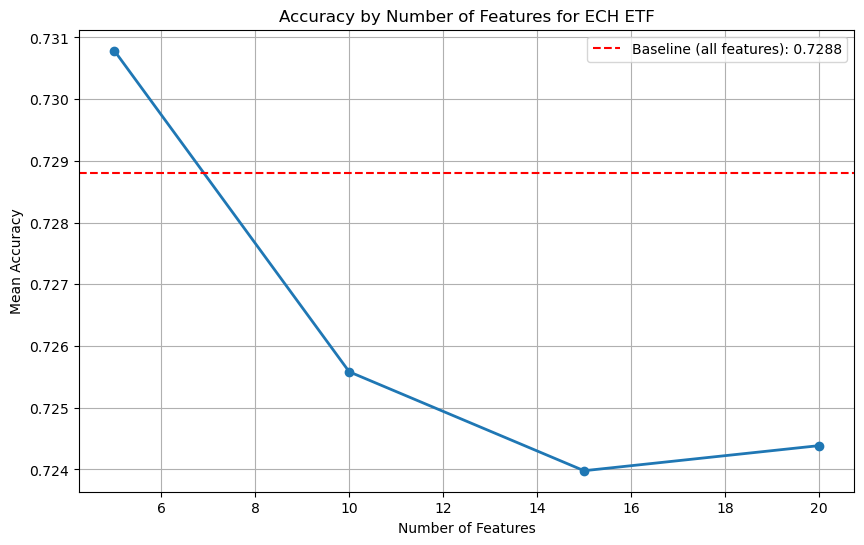

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(results_df['n_features'], results_df['mean_accuracy'], marker='o', linestyle='-', linewidth=2)
plt.axhline(y=cv_scores_all.mean(), color='r', linestyle='--', label=f'Baseline (all features): {cv_scores_all.mean():.4f}')
plt.xlabel('Number of Features')
plt.ylabel('Mean Accuracy')
plt.title('Accuracy by Number of Features for ECH ETF')
plt.grid(True)
plt.legend()
plt.savefig('ECH_accuracy_by_features.png')
plt.show()

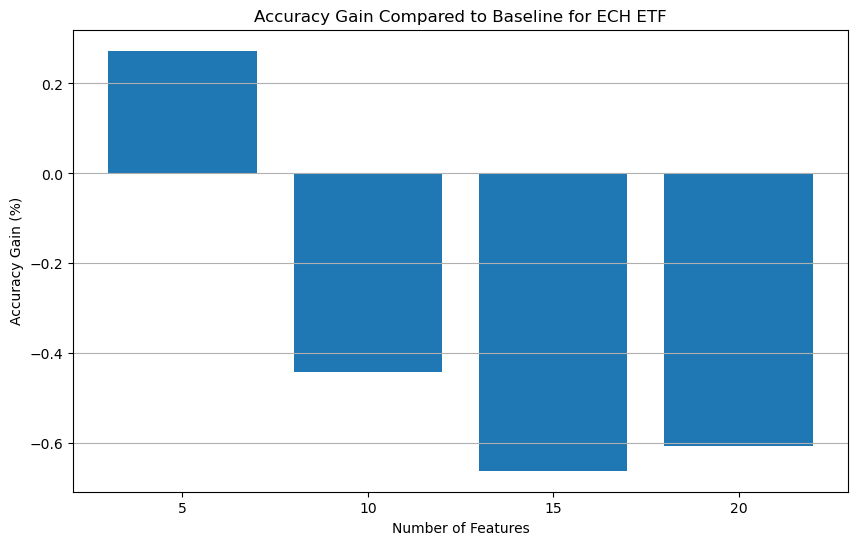

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(results_df['n_features'].astype(str), results_df['accuracy_gain_pct'])
plt.xlabel('Number of Features')
plt.ylabel('Accuracy Gain (%)')
plt.title('Accuracy Gain Compared to Baseline for ECH ETF')
plt.grid(True, axis='y')
plt.savefig('ECH_accuracy_gain.png')
plt.show()

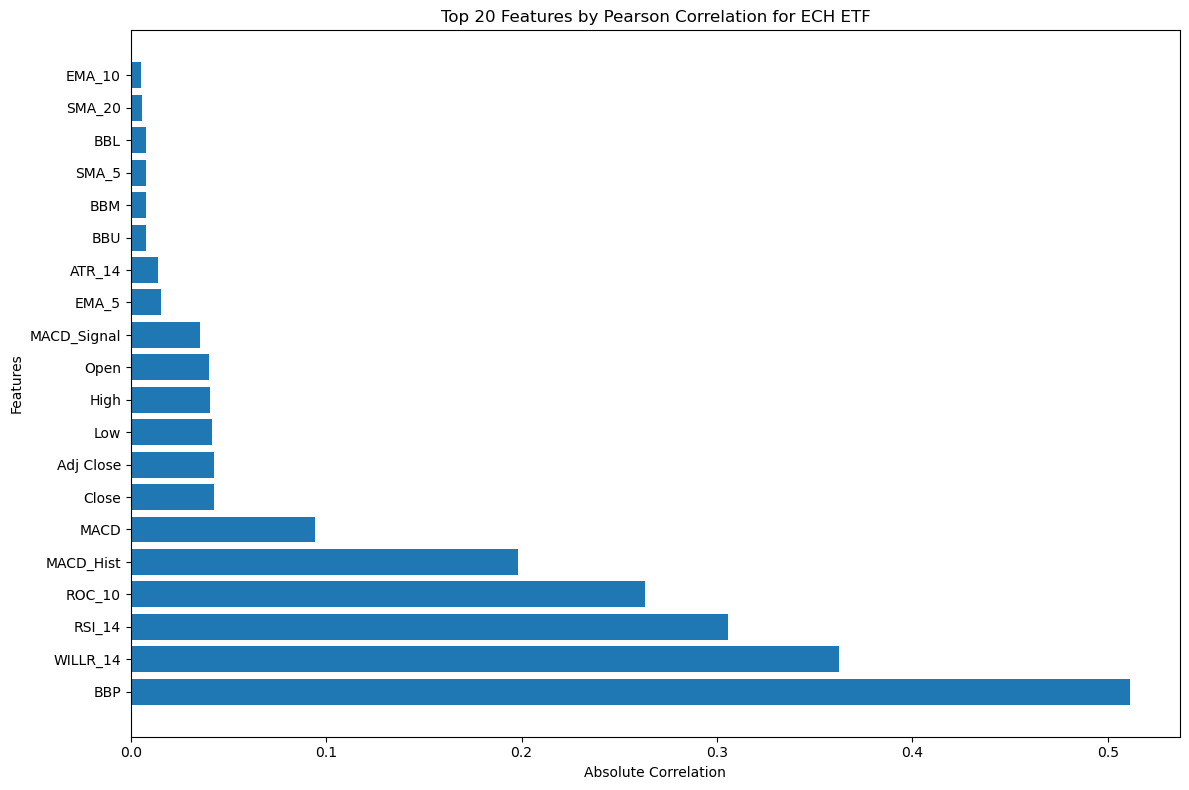

In [ ]:
top_20_features, feature_corrs = pearson_feature_selection(ech_indicators, 'Target', n_features=20)
plt.figure(figsize=(12, 8))
feature_corrs_sorted = feature_corrs[top_20_features]
plt.barh(range(len(feature_corrs_sorted)), feature_corrs_sorted.values, align='center')
plt.yticks(range(len(feature_corrs_sorted)), feature_corrs_sorted.index)
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.title('Top 20 Features by Pearson Correlation for ECH ETF')
plt.tight_layout()
plt.savefig('ECH_feature_importance.png')
plt.show()

This replication exercise demonstrates the key methodological components of the original research:
1. Acquisition and preprocessing of ETF time series data
2. Calculation of a comprehensive set of technical indicators
3. Implementation of Pearson's correlation for feature selection
4. Application of 10-fold cross-validation for robust performance estimation
5. Evaluation of model performance across different feature subset cardinalities
6. Comparison against a baseline model using the complete feature set
7. Visualization of empirical results

The code reproduces the performance table showing accuracy metrics for different feature subsets and generates visualizations to illustrate the relationship between feature dimensionality and predictive performance. The results should empirically validate the original paper's claim that a parsimonious set of carefully selected features can achieve comparable or superior performance to using the complete feature set, with significant computational efficiency gains.

**Part 2:**
 Download data from Meteostat for Valencia and do analysis.

5.  Python code to import and structure into useful data structures
6.  exploratory data analysis of sample data

In [2]:
!pip install meteostat

In [3]:
from datetime import datetime
from meteostat import Point, Daily
import pandas as pd

# Define the location (e.g., Valencia, Spain)
location = Point(39.4699, -0.3763)

# Define the time period
start = datetime(2024, 1, 1)
end = datetime(2024, 12, 31)

# Fetch daily weather data
data = Daily(location, start, end)
data = data.fetch()

# Display the first few rows
print(data.head())


            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2024-01-01  11.1   9.8  19.0   0.0   NaN  264.0  11.8   NaN  1019.7   NaN
2024-01-02  13.0   7.8  18.9   0.0   NaN  247.0  24.3   NaN  1019.8   NaN
2024-01-03  17.4  15.0  23.0   0.0   NaN  267.0  26.4   NaN  1017.0   NaN
2024-01-04  14.8  14.5  20.6   0.6   NaN  261.0  12.1   NaN  1014.8   NaN
2024-01-05  13.1  12.4  18.4   0.0   NaN  270.0  22.7   NaN  1006.0   NaN


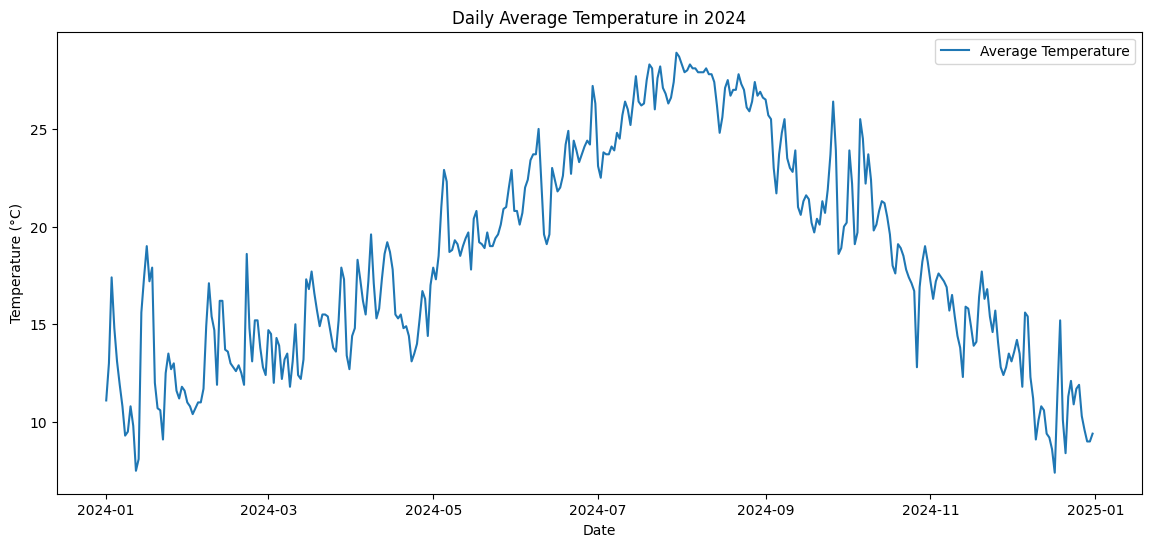

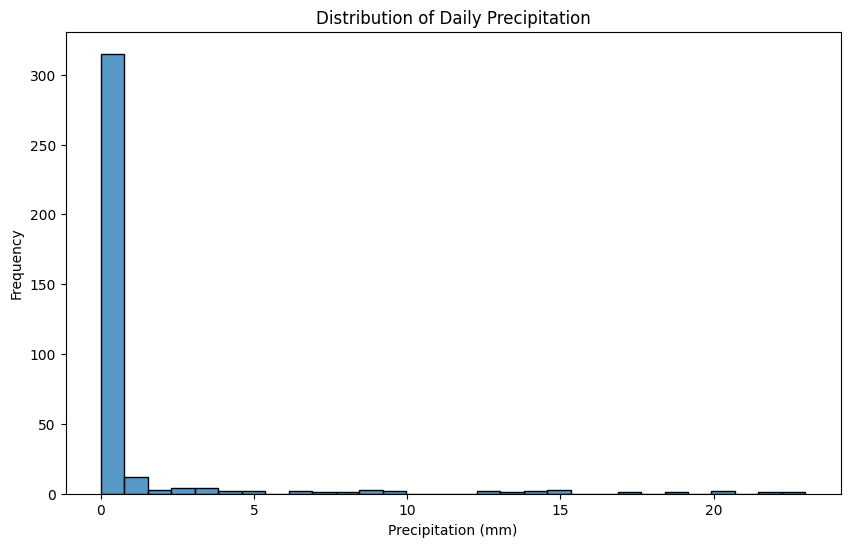

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot temperature over time
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['tavg'], label='Average Temperature')
plt.title('Daily Average Temperature in 2024')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# Histogram of precipitation
plt.figure(figsize=(10, 6))
sns.histplot(data['prcp'].dropna(), bins=30, kde=False)
plt.title('Distribution of Daily Precipitation')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Frequency')
plt.show()
